In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("C:/Users/Dell/Downloads/delivery_dataset_with_healthcare_products.csv")
# EDA
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (1000, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            1000 non-null   object 
 1   city                1000 non-null   object 
 2   courier_id          1000 non-null   object 
 3   origin_lat          1000 non-null   float64
 4   origin_lng          1000 non-null   float64
 5   dest_lat            1000 non-null   float64
 6   dest_lng            1000 non-null   float64
 7   order_time          1000 non-null   object 
 8   delivery_time       1000 non-null   object 
 9   healthcare_product  1000 non-null   object 
dtypes: float64(4), object(6)
memory usage: 78.3+ KB
None

Missing Values:
order_id              0
city                  0
courier_id            0
origin_lat            0
origin_lng            0
dest_lat              0
dest_lng              0
order_time            

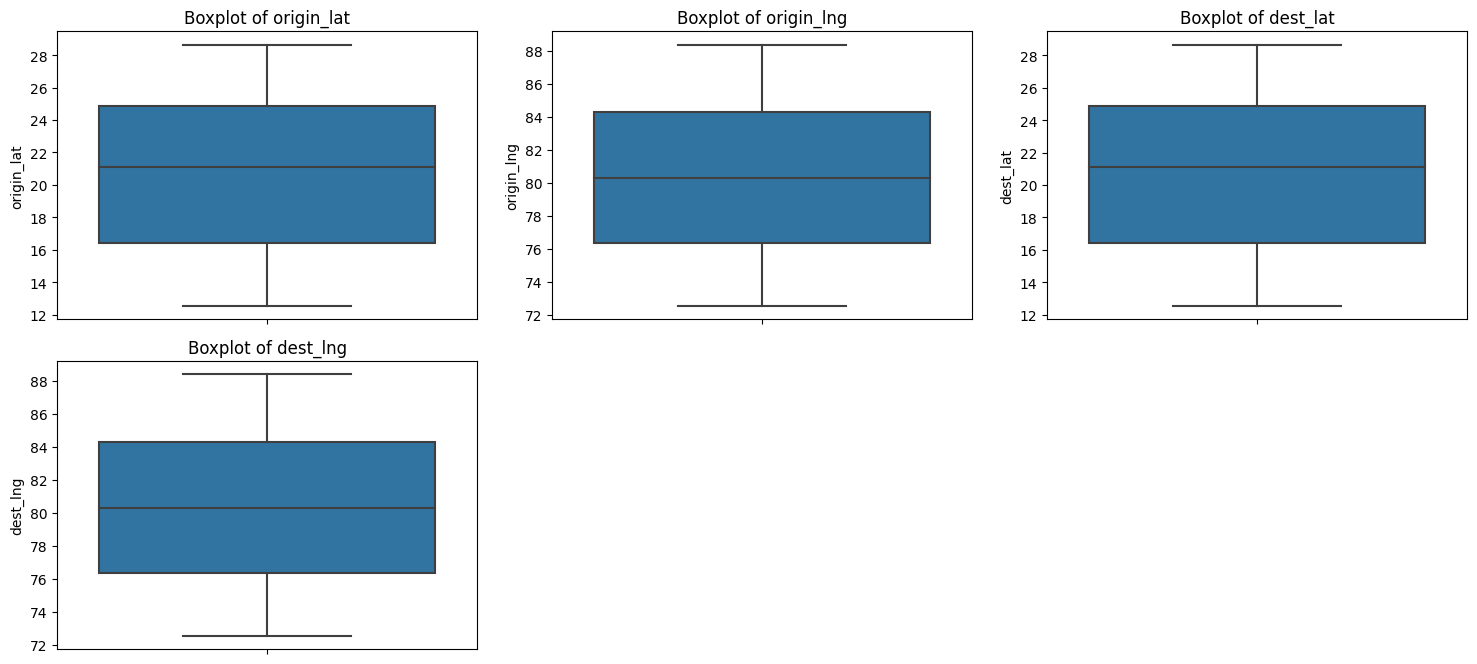

In [8]:
plt.figure(figsize=(15, 10))
numerical_cols = df.select_dtypes(include=[np.number]).columns
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

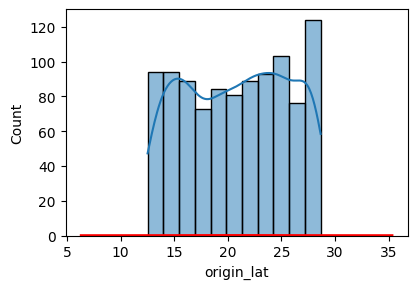

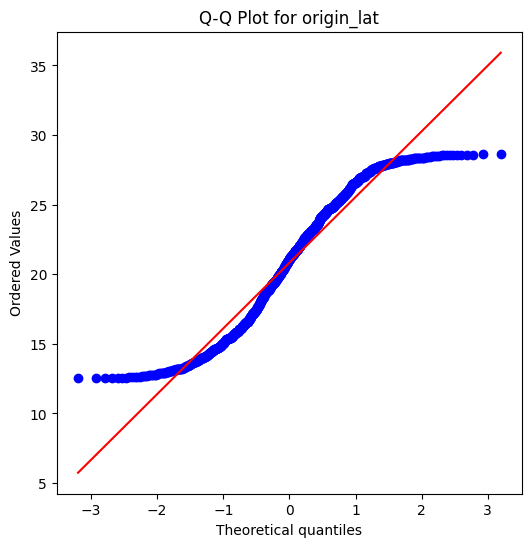

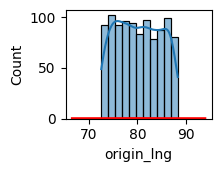

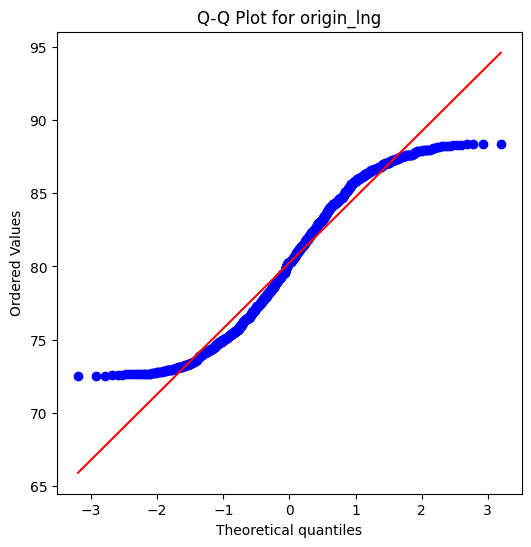

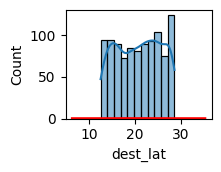

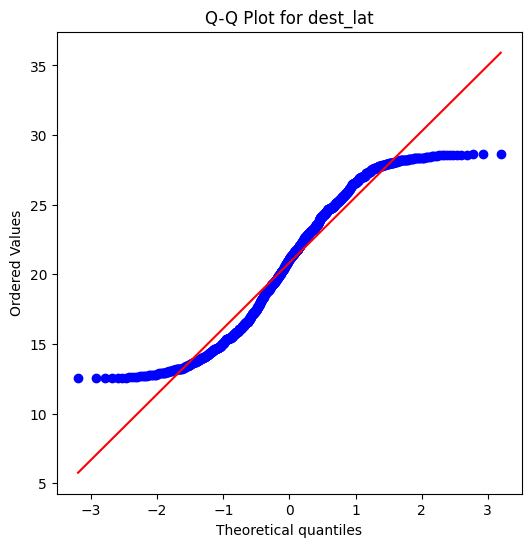

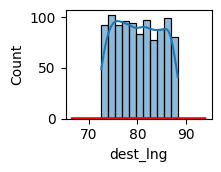

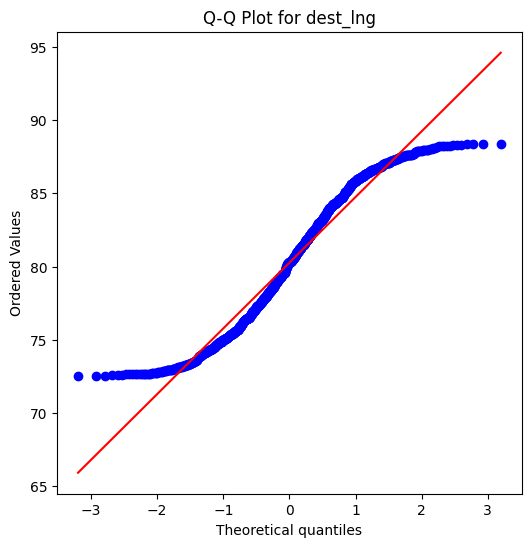

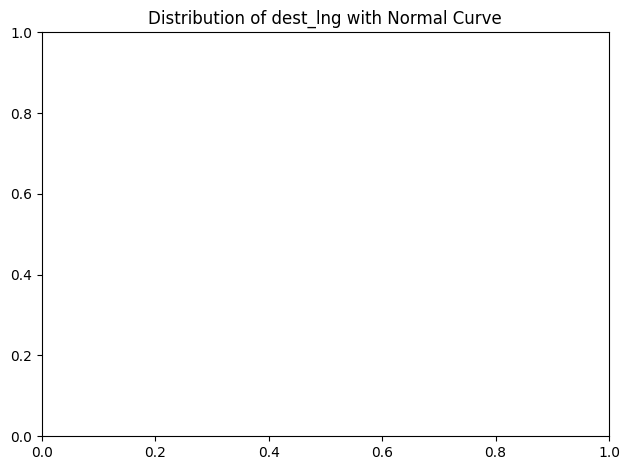

In [9]:
# Normal distribution analysis
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    
    # Plot histogram with KDE
    sns.histplot(data=df, x=col, kde=True)
    
    # Add normal distribution curve
    mu = df[col].mean()
    sigma = df[col].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal Distribution')
    
    # Add QQ plot
    plt.figure(figsize=(6, 6))
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {col}')
    plt.show()
    
    plt.title(f'Distribution of {col} with Normal Curve')
plt.tight_layout()
plt.show()


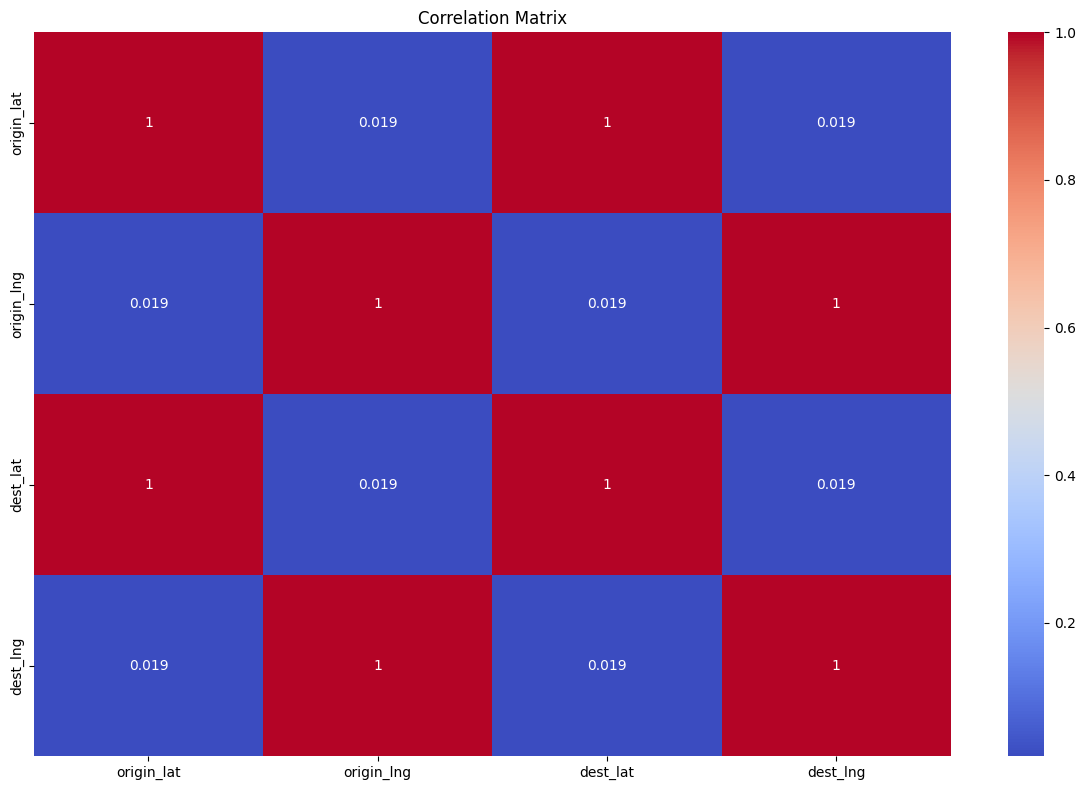

In [10]:
# Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [11]:
def preprocess_data(df):
    # Handle missing values
    df = df.fillna(df.mean())
    
    # Convert categorical variables to numerical using Label Encoding
    categorical_cols = df.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
    
    return df, label_encoders

In [12]:
# Prepare data for LSTM
def prepare_sequences(data, target_col, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Get sequence of features
        X.append(data[i:(i + sequence_length)])
        # Get target value (next value after sequence)
        y.append(data[i + sequence_length - 1, target_col])
    return np.array(X), np.array(y)

In [13]:
df_processed, label_encoders = preprocess_data(df)

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_processed)

In [22]:
# Prepare sequences for LSTM
sequence_length = 10
X, y = prepare_sequences(scaled_data, target_col=df_processed.columns.get_loc('delivery_time'))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64,input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [23]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
20/20 [==============================] - 16s 171ms/step - loss: 0.1321 - mae: 0.3002 - val_loss: 0.0868 - val_mae: 0.2569
Epoch 2/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0900 - mae: 0.2556 - val_loss: 0.0836 - val_mae: 0.2520
Epoch 3/50
20/20 [==============================] - 1s 36ms/step - loss: 0.0886 - mae: 0.2553 - val_loss: 0.0841 - val_mae: 0.2516
Epoch 4/50
20/20 [==============================] - 1s 34ms/step - loss: 0.0873 - mae: 0.2516 - val_loss: 0.0807 - val_mae: 0.2483
Epoch 5/50
20/20 [==============================] - 1s 38ms/step - loss: 0.0856 - mae: 0.2490 - val_loss: 0.0827 - val_mae: 0.2485
Epoch 6/50
20/20 [==============================] - 1s 38ms/step - loss: 0.0828 - mae: 0.2441 - val_loss: 0.0779 - val_mae: 0.2437
Epoch 7/50
20/20 [==============================] - 1s 36ms/step - loss: 0.0804 - mae: 0.2411 - val_loss: 0.0797 - val_mae: 0.2454
Epoch 8/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0780 -

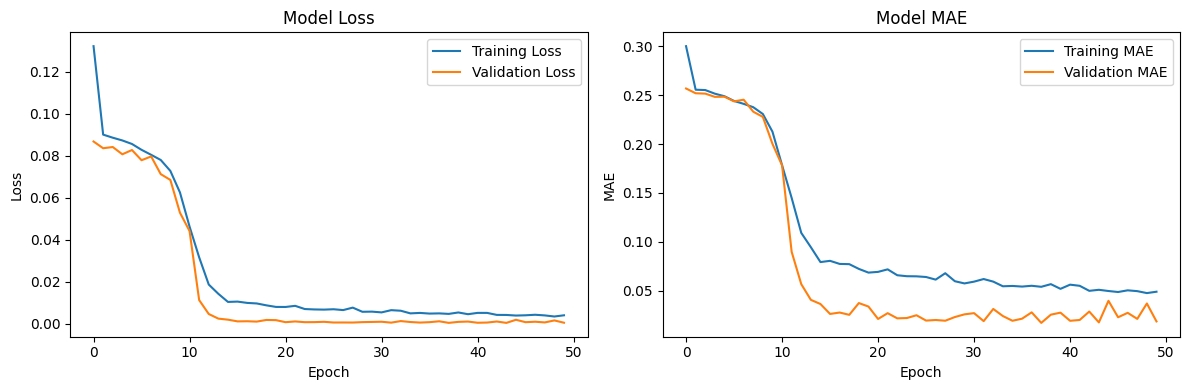

In [24]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MAE: {test_mae:.2f}")


Test MAE: 0.02


7/7 [==============================] - 2s 25ms/step


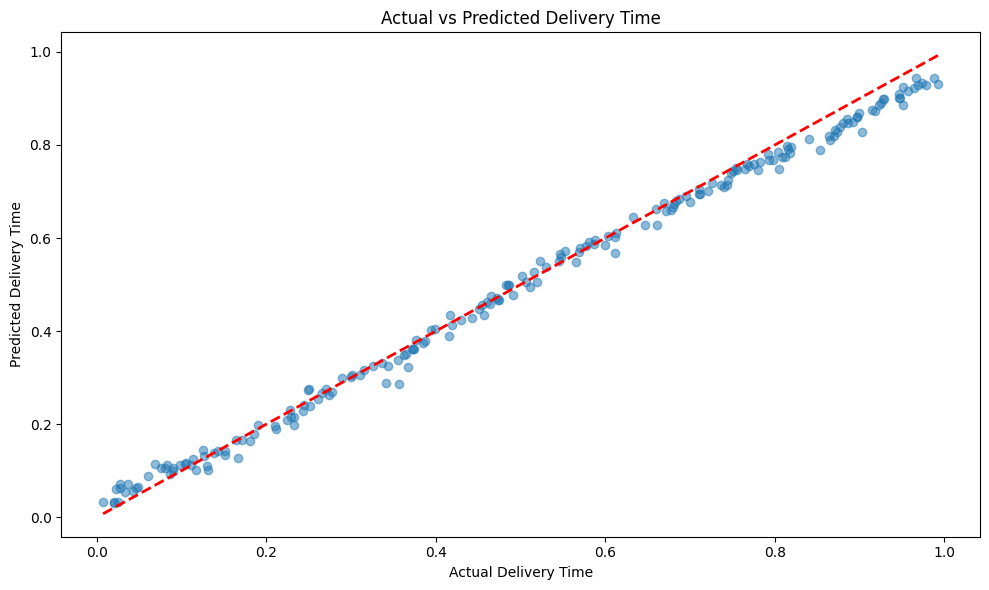

In [26]:
predictions = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs Predicted Delivery Time')
plt.tight_layout()
plt.show()


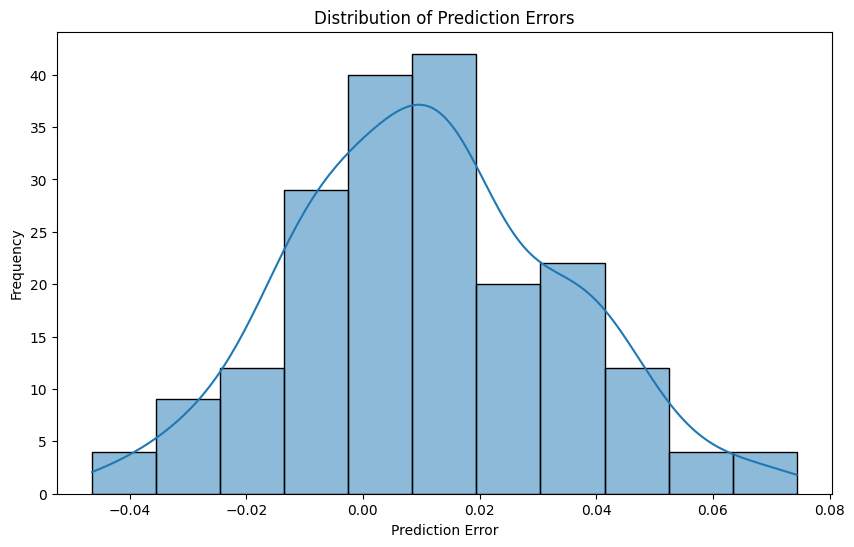

In [27]:
# Distribution of prediction errors
errors = y_test - predictions.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()
